In [ ]:
# !wget "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip"
# !unzip -q flickr8k.zip -d ./flickr8k
# !rm flickr8k.zip
# !echo "Downloaded Flickr8k dataset successfully."




'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


"Downloaded Flickr8k dataset successfully."


In [2]:
import pandas as pd

# Load captions
df = pd.read_csv('./flickr8k/captions.txt')
print(df.head())

                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [6]:
import re

def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r"[^a-z ]+", "", caption)
    caption = caption.strip()
    return f"<start> {caption} <end>"

# Apply cleaning
df['cleaned_caption'] = df['caption'].apply(clean_caption)
print(df.head())


                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going into a wooden building .   
2   A little girl climbing into a wooden playhouse .   
3  A little girl climbing the stairs to her playh...   
4  A little girl in a pink dress going into a woo...   

                                     cleaned_caption  
0  <start> a child in a pink dress is climbing up...  
1  <start> a girl going into a wooden building <end>  
2  <start> a little girl climbing into a wooden p...  
3  <start> a little girl climbing the stairs to h...  
4  <start> a little girl in a pink dress going in...  


In [7]:
df['caption'][0]

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [8]:
df['cleaned_caption'][0]

'<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>'

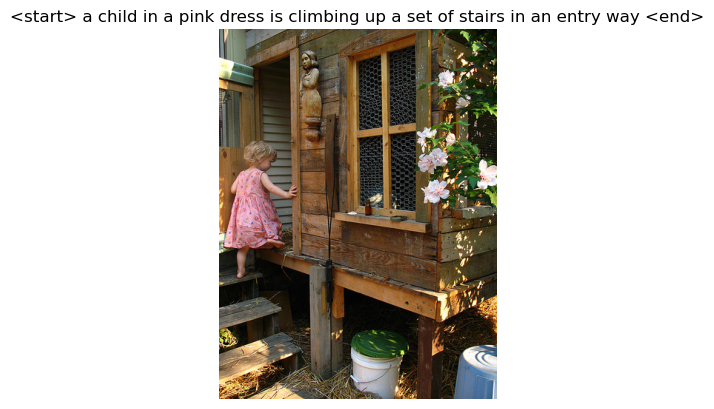

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

sample_img = './flickr8k/Images/' + df.iloc[0]['image']
sample_caption = df.iloc[0]['cleaned_caption']

img = Image.open(sample_img)
plt.imshow(img)
plt.title(sample_caption)
plt.axis('off')
plt.show()


In [10]:
from collections import Counter

# Gather all words from cleaned captions
all_captions = df['cleaned_caption'].tolist()
all_words = []
for caption in all_captions:
    all_words.extend(caption.split())

# Count word frequencies
word_counts = Counter(all_words)
print(f"Total unique words (before filtering): {len(word_counts)}")
print(word_counts.most_common(10))  # Show top 10 words


Total unique words (before filtering): 8780
[('a', 62986), ('<start>', 40455), ('<end>', 40455), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136), ('with', 7765)]


In [11]:
# Set threshold for rare words
threshold = 5
vocab = [word for word, count in word_counts.items() if count >= threshold]
print(f"Vocabulary size (after threshold={threshold}): {len(vocab)}")


Vocabulary size (after threshold=5): 2986


In [12]:
# Add special tokens
vocab = ['<pad>', '<start>', '<end>', '<unk>'] + vocab

# Create mappings
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

print(f"Sample word2idx: {list(word2idx.items())[:20]}")


Sample word2idx: [('<pad>', 0), ('<start>', 4), ('<end>', 18), ('<unk>', 3), ('a', 5), ('child', 6), ('in', 7), ('pink', 8), ('dress', 9), ('is', 10), ('climbing', 11), ('up', 12), ('set', 13), ('of', 14), ('stairs', 15), ('an', 16), ('way', 17), ('girl', 19), ('going', 20), ('into', 21)]


In [13]:

def caption_to_indices(caption, word2idx):
    # Check if word is in vocabulary, if not use '<unk>' token's index,
    # making sure it's within vocabulary size
    return [word2idx.get(word, word2idx['<unk>']) if word2idx.get(word, word2idx['<unk>']) < len(word2idx) else word2idx['<pad>'] for word in caption.split()]

df['caption_indices'] = df['cleaned_caption'].apply(lambda cap: caption_to_indices(cap, word2idx))


In [14]:
df['caption_indices'][10]

[4, 5, 24, 19, 56, 7, 57, 58, 7, 59, 14, 5, 60, 61, 37, 28, 62, 7, 5, 63, 18]

In [15]:

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use EfficientNet-B0
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

# Load weights + transforms
weights = EfficientNet_B7_Weights.IMAGENET1K_V1
efficientnet = efficientnet_b7(weights=weights)
efficientnet.classifier = nn.Identity()  # Remove classifier for feature extraction
efficientnet = efficientnet.to(device)
efficientnet.eval()

# Use predefined transform
transform = weights.transforms()


# Feature extraction function with EfficientNet
def extract_feature_efficientnet(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = efficientnet(image)  # [1, 1280] for EfficientNet-B0
    return feature.squeeze(0).cpu()


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
print(transform)

ImageClassification(
    crop_size=[600]
    resize_size=[600]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [18]:
import torchvision.transforms as transforms
from PIL import Image




In [16]:
import os
import pickle

features_dict = {}
image_folder = './flickr8k/Images/'

for img_name in df['image'].unique():
    img_path = os.path.join(image_folder, img_name)
    features = extract_feature_efficientnet(img_path)
    features_dict[img_name] = features



In [ ]:
import pickle
# Save extracted features
with open('features_efficentnet.pkl', 'wb') as f:
    pickle.dump(features_dict, f)

print("Extracted and saved features for all images using Efficientnet.")

Extracted and saved features for all images using Efficientnet.


In [19]:
import pickle

# Load pre-extracted features
with open('features_efficentnet.pkl', 'rb') as f:
    features_dict = pickle.load(f)

print(f"Total features loaded: {len(features_dict)}")


Total features loaded: 8091


In [20]:
len(features_dict['1000268201_693b08cb0e.jpg'])

2560

In [21]:
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:
class FlickrDataset(Dataset):
    def __init__(self, dataframe, features_dict, word2idx, max_len=25):
        self.df = dataframe
        self.features_dict = features_dict
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_name = row['image']
        caption_idx = row['caption_indices']
        feature = self.features_dict[image_name]

        feature = feature.float()
        caption_idx = torch.tensor(caption_idx, dtype=torch.long)
        return feature, caption_idx

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    features, captions = zip(*batch)
    features = torch.stack(features, 0)
    captions = pad_sequence(captions, batch_first=True, padding_value=word2idx['<pad>'])
    return features, captions


In [23]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = FlickrDataset(train_df, features_dict, word2idx)
val_dataset = FlickrDataset(val_df, features_dict, word2idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [24]:
# Get one batch from the DataLoader
features_batch, captions_batch = next(iter(train_loader))

print(f"Features batch shape: {features_batch.shape}")  # Should be (batch_size, 2048)
print(f"Captions batch shape: {captions_batch.shape}")  # Should be (batch_size, max_seq_len)

# Let's look at the first feature vector and caption
print(f"First image feature vector (shape): {features_batch[0].shape}")
print(f"First caption indices: {captions_batch[0]}")



Features batch shape: torch.Size([32, 2560])
Captions batch shape: torch.Size([32, 25])
First image feature vector (shape): torch.Size([2560])
First caption indices: tensor([  4,   5, 397, 804,   5, 395,  37, 567, 155,  40,  18,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])


In [25]:
def decode_caption(indices, idx2word):
    words = [idx2word[idx.item()] for idx in indices if idx.item() not in [word2idx['<pad>']]]
    return ' '.join(words)

# Example: Decode first caption in batch
decoded_caption = decode_caption(captions_batch[0], idx2word)
print(f"Decoded Caption: {decoded_caption}")


Decoded Caption: <start> a skateboarder attempts a trick with no shirt on <end>


In [26]:
vocab_size = len(word2idx)
max_idx = 0
min_idx = vocab_size

for i in range(len(df)):
    caption_indices = df.iloc[i]['caption_indices']
    max_idx = max(max_idx, max(caption_indices))
    min_idx = min(min_idx, min(caption_indices))

print(f"Min index in captions: {min_idx}")
print(f"Max index in captions: {max_idx}")
print(f"Vocab size: {vocab_size}")

if max_idx >= vocab_size or min_idx < 0:
    print("❌ Some indices are out of bounds!")
else:
    print("✅ All indices are within valid range!")


Min index in captions: 0
Max index in captions: 2987
Vocab size: 2988
✅ All indices are within valid range!


In [27]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(2560, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, features):
        features = self.fc(features)
        features = self.bn(features)
        return features

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.2):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        captions = torch.clamp(captions, 0, len(word2idx) - 1)
        embeddings = self.embed(captions[:, :-1])
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.fc(hiddens)
        return outputs

class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, features, captions):
        features = self.encoder(features)
        outputs = self.decoder(features, captions)
        return outputs


In [28]:
def calculate_accuracy(outputs, targets):
    _, predicted = outputs.max(2)  # [batch_size, seq_len]
    correct = (predicted == targets) & (targets != word2idx['<pad>'])
    total = (targets != word2idx['<pad>']).sum().item()
    correct_total = correct.sum().item()
    return correct_total / total if total > 0 else 0


In [29]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def evaluate_with_acc(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for features, captions in val_loader:
            features, captions = features.to(device), captions.to(device)
            outputs = model(features, captions)
            
            outputs = outputs[:, :-1, :]
            targets = captions[:, 1:]

            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            acc = calculate_accuracy(outputs, targets)

            val_loss += loss.item()
            val_acc += acc

    return val_loss / len(val_loader), val_acc / len(val_loader)



def train(model, data_loader, criterion, optimizer, num_epochs, val_loader=None):
    early_stopping = EarlyStopping(patience=5)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
      model.train()
      total_loss = 0
      total_acc = 0

      for features, captions in data_loader:
          features, captions = features.to(device), captions.to(device)

          outputs = model(features, captions)
          outputs = outputs[:, :-1, :]
          targets = captions[:, 1:]

          loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
          acc = calculate_accuracy(outputs, targets)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          total_acc += acc

      avg_loss = total_loss / len(data_loader)
      avg_acc = total_acc / len(data_loader)
      train_loss_history.append(avg_loss)
      train_acc_history.append(avg_acc)
      print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f}")

      if val_loader:
          val_loss, val_acc = evaluate_with_acc(model, val_loader, criterion)
          val_loss_history.append(val_loss)
          val_acc_history.append(val_acc)
          print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")
          # scheduler.step(val_loss)  # <--- Adjust LR based on val_loss
          early_stopping(val_loss)
      else:
          early_stopping(avg_loss)

      if early_stopping.early_stop:
          print("Early stopping triggered.")
          break
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Acc')
    plt.plot(val_acc_history, label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



Epoch [1/50], Train Loss: 4.4230, Train Acc: 0.2289
Validation Loss: 3.9819, Validation Acc: 0.2643
Epoch [2/50], Train Loss: 3.7776, Train Acc: 0.2757
Validation Loss: 3.6704, Validation Acc: 0.2877
Epoch [3/50], Train Loss: 3.4824, Train Acc: 0.2985
Validation Loss: 3.5161, Validation Acc: 0.3029
Epoch [4/50], Train Loss: 3.2726, Train Acc: 0.3149
Validation Loss: 3.4309, Validation Acc: 0.3112
Epoch [5/50], Train Loss: 3.0931, Train Acc: 0.3323
Validation Loss: 3.3899, Validation Acc: 0.3185
Epoch [6/50], Train Loss: 2.9205, Train Acc: 0.3489
Validation Loss: 3.3702, Validation Acc: 0.3243
Epoch [7/50], Train Loss: 2.7537, Train Acc: 0.3682
Validation Loss: 3.3786, Validation Acc: 0.3258
Epoch [8/50], Train Loss: 2.5899, Train Acc: 0.3889
Validation Loss: 3.4114, Validation Acc: 0.3243
Epoch [9/50], Train Loss: 2.4310, Train Acc: 0.4126
Validation Loss: 3.4689, Validation Acc: 0.3260
Epoch [10/50], Train Loss: 2.2810, Train Acc: 0.4372
Validation Loss: 3.5153, Validation Acc: 0.3262

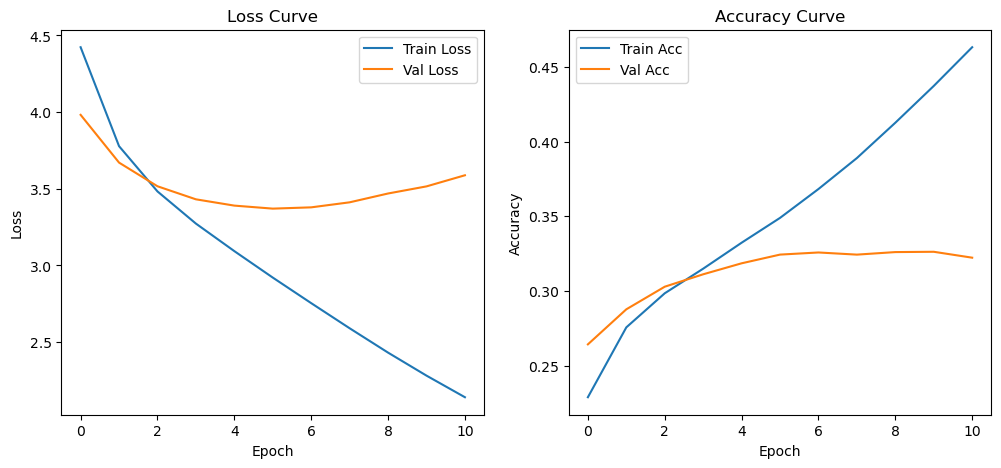

In [57]:
vocab_size = len(word2idx)
embed_size = 512  # Bigger embedding for more capacity
hidden_size = 1024  # Bigger LSTM hidden size

encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers=3, dropout=0.2).to(device)
model = ImageCaptioningModel(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True, min_lr=0.00000001)



train(model, train_loader, criterion, optimizer, num_epochs=50, val_loader=val_loader)


In [123]:
!pip install torchinfo

In [58]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
ImageCaptioningModel                     --
├─Encoder: 1-1                           --
│    └─Linear: 2-1                       1,311,232
│    └─BatchNorm1d: 2-2                  1,024
├─Decoder: 1-2                           --
│    └─Embedding: 2-3                    1,529,856
│    └─LSTM: 2-4                         23,093,248
│    └─Linear: 2-5                       3,062,700
Total params: 28,998,060
Trainable params: 28,998,060
Non-trainable params: 0

In [74]:
# Save Encoder and Decoder weights
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')



print("Models saved successfully!")


Models saved successfully!


In [75]:


# Load weights into models
encoder.load_state_dict(torch.load('encoder.pth'))
decoder.load_state_dict(torch.load('decoder.pth'))

encoder.eval()
decoder.eval()

print("Models loaded successfully!")


Models loaded successfully!


In [59]:
def generate_caption(model, feature, word2idx, idx2word, max_len=20):
    model.eval()
    result_caption = []

    # Encode the feature
    feature = feature.unsqueeze(0).to(device)  # [1, 2048]
    with torch.no_grad():
        feature = model.encoder(feature)  # [1, embed_size]

    # Start token
    word_idx = torch.tensor([word2idx['<start>']]).to(device)
    caption = [word_idx]

    for _ in range(max_len):
        caption_tensor = torch.tensor(caption).unsqueeze(0).to(device)  # [1, seq_len]
        with torch.no_grad():
            embeddings = model.decoder.embed(caption_tensor)  # [1, seq_len, embed_size]
            inputs = torch.cat((feature.unsqueeze(1), embeddings), dim=1)  # [1, seq_len+1, embed_size]
            hiddens, _ = model.decoder.lstm(inputs)
            outputs = model.decoder.fc(hiddens)  # [1, seq_len+1, vocab_size]

        # Take the last word's prediction
        outputs = outputs.squeeze(0)  # [seq_len+1, vocab_size]
        _, predicted = outputs[-1].max(0)  # last time step

        next_word = idx2word[predicted.item()]
        if next_word == '<end>':
            break

        result_caption.append(next_word)
        caption.append(predicted)

    return ' '.join(result_caption)


In [60]:
def generate_caption_beam_search(model, feature, word2idx, idx2word, beam_size=3, max_len=20):
    model.eval()
    feature = feature.unsqueeze(0).to(device)
    feature = model.encoder(feature)

    sequences = [[list(), 0.0, feature]]
    for _ in range(max_len):
        all_candidates = []
        for seq, score, feature in sequences:
            if len(seq) > 0 and seq[-1] == word2idx['<end>']:
                all_candidates.append((seq, score, feature))
                continue
            inputs = torch.tensor([seq], dtype=torch.long).to(device)
            if len(inputs[0]) == 0:
                inputs = torch.tensor([[word2idx['<start>']]], dtype=torch.long).to(device)
            outputs = model.decoder(feature, inputs)
            outputs = outputs[:, -1, :]  # Get the last word prediction
            probs = torch.nn.functional.log_softmax(outputs, dim=1)
            top_probs, top_idx = probs.topk(beam_size)

            for i in range(beam_size):
                candidate = seq + [top_idx[0][i].item()]
                candidate_score = score - top_probs[0][i].item()
                all_candidates.append((candidate, candidate_score, feature))

        sequences = sorted(all_candidates, key=lambda tup: tup[1])[:beam_size]

    best_seq = sequences[0][0]
    caption = [idx2word[idx] for idx in best_seq if idx != word2idx['<start>'] and idx != word2idx['<end>']]
    return ' '.join(caption)


Generated Caption: boy on edge water while in lake


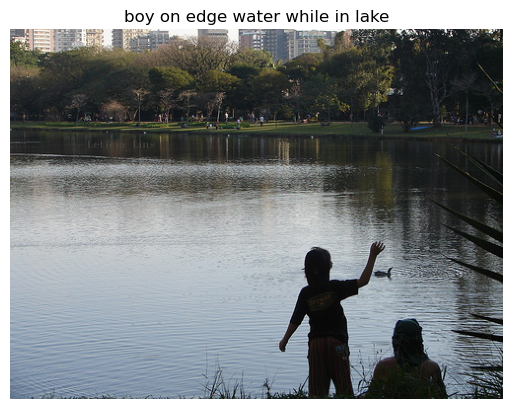

In [65]:
# Load one sample image and extract its feature
sample_image = './flickr8k/Images/' + df.iloc[80]['image']
sample_feature = extract_feature_efficientnet(sample_image).to(device)

# Generate caption
caption = generate_caption(model, sample_feature, word2idx, idx2word)
print(f"Generated Caption: {caption}")

# Show the image
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(sample_image)
plt.imshow(img)
plt.title(caption)
plt.axis('off')
plt.show()


Generated Caption: a a boy eats a food


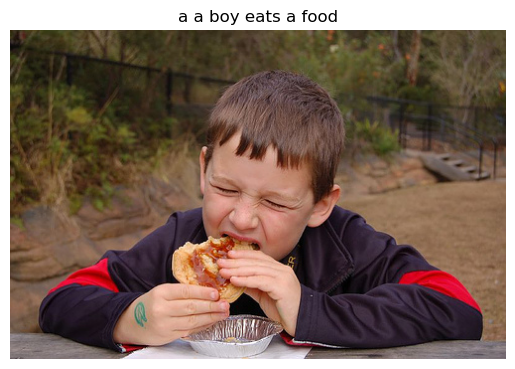

In [69]:
# Load one sample image and extract its feature
sample_image = './flickr8k/Images/' + df.iloc[150]['image']
sample_feature = extract_feature_efficientnet(sample_image).to(device)

# Generate caption
caption = generate_caption_beam_search(model, sample_feature, word2idx, idx2word)
print(f"Generated Caption: {caption}")

# Show the image
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(sample_image)
plt.imshow(img)
plt.title(caption)
plt.axis('off')
plt.show()


In [47]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt')


[nltk_data] Downloading package punkt to C:\Users\SONU
[nltk_data]     SONI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [70]:
def calculate_bleu(model, dataframe, features_dict, word2idx, idx2word, max_samples=100):
    model.eval()
    smoothie = SmoothingFunction().method4  # Helps avoid zero scores for small sentences
    
    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    bleu4_scores = []

    for i in range(min(len(dataframe), max_samples)):
        image_name = dataframe.iloc[i]['image']
        references = dataframe[dataframe['image'] == image_name]['cleaned_caption'].tolist()
        references = [ref.split() for ref in references]  # tokenized references

        # Extract feature for the image
        feature = features_dict[image_name].to(device)
        
        # Generate prediction
        generated = generate_caption(model, feature, word2idx, idx2word)
        candidate = generated.split()  # tokenized candidate caption

        # Calculate BLEU scores
        bleu1 = sentence_bleu(references, candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)
        bleu2 = sentence_bleu(references, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
        bleu3 = sentence_bleu(references, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
        bleu4 = sentence_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

        bleu1_scores.append(bleu1)
        bleu2_scores.append(bleu2)
        bleu3_scores.append(bleu3)
        bleu4_scores.append(bleu4)

    avg_bleu1 = sum(bleu1_scores) / len(bleu1_scores)
    avg_bleu2 = sum(bleu2_scores) / len(bleu2_scores)
    avg_bleu3 = sum(bleu3_scores) / len(bleu3_scores)
    avg_bleu4 = sum(bleu4_scores) / len(bleu4_scores)

    print(f"BLEU-1: {avg_bleu1:.4f}")
    print(f"BLEU-2: {avg_bleu2:.4f}")
    print(f"BLEU-3: {avg_bleu3:.4f}")
    print(f"BLEU-4: {avg_bleu4:.4f}")


In [72]:
calculate_bleu(model, val_df, features_dict, word2idx, idx2word, max_samples=1000)


BLEU-1: 0.1847
BLEU-2: 0.0569
BLEU-3: 0.0323
BLEU-4: 0.0210


In [3]:
!pip install transformers

   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ------------- -------------------------- 3.4/10.4 MB 18.3 MB/s eta 0:00:01
   ---------------------------- ----------- 7.3/10.4 MB 18.1 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 18.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 19.9 MB/s eta 0:00:00


In [4]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests

# Load pretrained BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Load an image


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

c:\sonu\anaconda\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\SONU SONI\.cache\huggingface\hub\models--Salesforce--blip-image-captioning-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Generated caption: a boy eating a piece of pizza


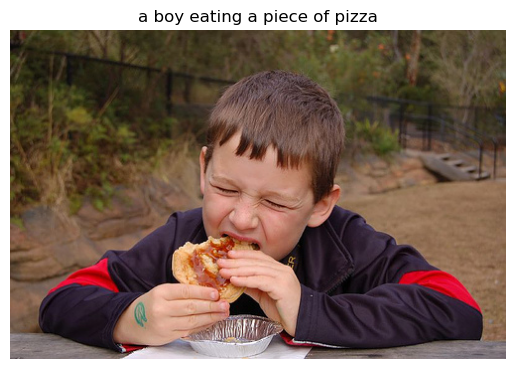

In [5]:
# Load an image
img_path = "./flickr8k/Images/" + df.iloc[150]['image']  # change to your image path
image = Image.open(img_path)

# Preprocess and generate
inputs = processor(image, return_tensors="pt")
out = model.generate(**inputs)
caption = processor.decode(out[0], skip_special_tokens=True)

print("Generated caption:", caption)

import matplotlib.pyplot as plt

img = Image.open(img_path)
plt.imshow(img)
plt.title(caption)
plt.axis('off')
plt.show()

In [51]:
!pip install transformers evaluate nltk


In [54]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to C:\Users\SONU
[nltk_data]    |     SONI\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to C:\Users\SONU
[nltk_data]    |     SONI\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\SONU SONI\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\SONU SONI\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\SONU SONI\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_da

True

In [56]:
import evaluate

# Load BLEU metric
bleu = evaluate.load("bleu")
predictions = ["a man riding a horse by the sea"]
references = [["a man riding a horse on the beach", "person on a horse at the seaside"]]


from nltk.tokenize import word_tokenize

predictions = [gen_caption.lower()]  # already string
references = [gt_captions]           # list of ground truth captions as strings

results = bleu.compute(predictions=predictions, references=references)
print(results)




{'bleu': 0.5410822690539396, 'precisions': [0.75, 0.5714285714285714, 0.5, 0.4], 'brevity_penalty': 1.0, 'length_ratio': 1.1428571428571428, 'translation_length': 8, 'reference_length': 7}
